# 🧾 Giới thiệu bộ dữ liệu SBA

Dữ liệu SBA cung cấp thông tin chi tiết về các khoản vay hỗ trợ doanh nghiệp nhỏ tại Mỹ, bao gồm:
- Thông tin doanh nghiệp (tên, vị trí, ngành nghề)
- Ngân hàng cho vay và thời điểm phê duyệt
- Số tiền giải ngân, số việc làm được tạo/gìn giữ
- Trạng thái hệ thống, tình trạng xoá nợ, v.v.

Trong notebook này, chúng ta sẽ:
1. Làm sạch dữ liệu
2. Khám phá dữ liệu thông qua trực quan hoá
3. Đưa ra một số nhận định ban đầu


In [15]:
pip install pandas matplotlib seaborn

Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip is available: 25.0.1 -> 25.1.1
[notice] To update, run: python.exe -m pip install --upgrade pip


In [2]:
# --- Import thư viện cần thiết ---
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings("ignore")


## 📥 Đọc và khám phá dữ liệu ban đầu

Chúng ta sẽ đọc file `SBAnational.csv`, kiểm tra kích thước và kiểu dữ liệu của từng cột.


In [3]:
# --- 1. Đọc dữ liệu ---
df = pd.read_csv("SBAnational.csv", low_memory=False)
print("Kích thước ban đầu:", df.shape)


Kích thước ban đầu: (899164, 27)


In [4]:
# --- 2. Xem sơ lược dữ liệu ---
print(df.info())
print(df.head())


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 899164 entries, 0 to 899163
Data columns (total 27 columns):
 #   Column             Non-Null Count   Dtype  
---  ------             --------------   -----  
 0   LoanNr_ChkDgt      899164 non-null  int64  
 1   Name               899150 non-null  object 
 2   City               899134 non-null  object 
 3   State              899150 non-null  object 
 4   Zip                899164 non-null  int64  
 5   Bank               897605 non-null  object 
 6   BankState          897598 non-null  object 
 7   NAICS              899164 non-null  int64  
 8   ApprovalDate       899164 non-null  object 
 9   ApprovalFY         899164 non-null  object 
 10  Term               899164 non-null  int64  
 11  NoEmp              899164 non-null  int64  
 12  NewExist           899028 non-null  float64
 13  CreateJob          899164 non-null  int64  
 14  RetainedJob        899164 non-null  int64  
 15  FranchiseCode      899164 non-null  int64  
 16  Ur

## 🧼 Làm sạch dữ liệu: Chuyển định dạng ngày

Các cột ngày như `ApprovalDate`, `DisbursementDate`, `ChgOffDate` sẽ được chuyển về kiểu `datetime`.


In [5]:
# --- 3. Chuyển đổi các cột ngày ---
date_cols = ['ApprovalDate', 'ChgOffDate', 'DisbursementDate']
for col in date_cols:
    df[col] = pd.to_datetime(df[col], errors='coerce')


## 💵 Làm sạch dữ liệu: Chuẩn hóa số tiền và xử lý giá trị thiếu

- Xoá ký tự `$`, `,` khỏi các cột tiền tệ rồi chuyển sang kiểu `float`
- Loại bỏ các dòng thiếu dữ liệu quan trọng như ngày phê duyệt hoặc số tiền giải ngân
- Điền giá trị thiếu cho `MIS_Status` là `"PENDING"`


In [6]:
# --- 4. Làm sạch dữ liệu số tiền (xoá dấu $ hoặc dấu phẩy) ---
money_cols = ['DisbursementGross', 'BalanceGross', 'ChgOffPrinGr', 'GrAppv', 'SBA_Appv']
for col in money_cols:
    df[col] = df[col].replace('[\$,]', '', regex=True).astype(float)

In [7]:
# --- 5. Xử lý giá trị thiếu ---
# Loại bỏ các dòng thiếu dữ liệu trọng yếu
df = df.dropna(subset=['ApprovalDate', 'DisbursementGross'])

# Điền giá trị thiếu cho MIS_Status
df['MIS_Status'] = df['MIS_Status'].fillna("PENDING")

## 🆕 Tạo cột phụ: Năm và trạng thái bị xóa nợ

- Tạo cột `Year` từ `ApprovalDate` để phân tích theo năm
- Tạo cột `ChargedOff`: True nếu khoản vay bị xóa nợ


In [8]:
# --- 6. Tạo cột phụ ---
df['Year'] = df['ApprovalDate'].dt.year
df['ChargedOff'] = df['ChgOffDate'].notnull()


In [9]:
# --- 7. In lại kích thước sau làm sạch ---
print("Kích thước sau làm sạch:", df.shape)

Kích thước sau làm sạch: (899164, 29)


### ========================================================
### ================== TRỰC QUAN HÓA DỮ LIỆU ====================
### ========================================================

## 📊 Số lượng khoản vay được phê duyệt theo từng năm

Trực quan hóa số khoản vay SBA được duyệt theo từng năm để tìm xu hướng hoạt động theo thời gian.


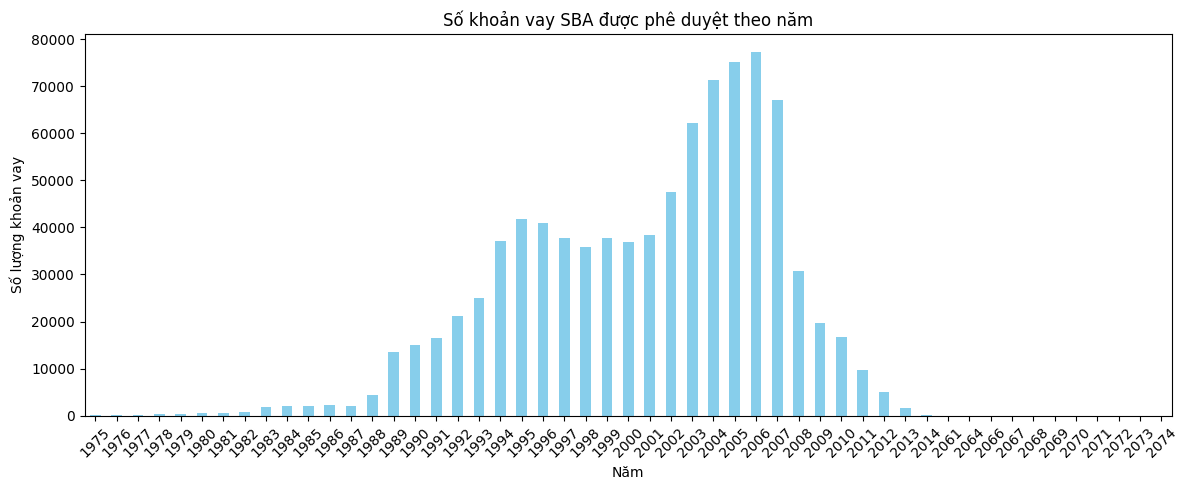

In [10]:
# --- Biểu đồ 1: Số khoản vay mỗi năm ---
plt.figure(figsize=(12,5))
df.groupby('Year').size().plot(kind='bar', color='skyblue')
plt.title("Số khoản vay SBA được phê duyệt theo năm")
plt.xlabel("Năm")
plt.ylabel("Số lượng khoản vay")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

### 1. Số khoản vay SBA được phê duyệt theo năm

Xu hướng: Số lượng khoản vay tăng mạnh từ đầu thập niên 1990, đạt đỉnh vào khoảng 2005–2007, sau đó giảm nhanh.

Kết luận: SBA mở rộng hỗ trợ mạnh mẽ cho doanh nghiệp nhỏ trong giai đoạn 1995–2007, có thể do các chính sách thúc đẩy kinh tế hoặc nhu cầu vay vốn tăng cao. Sau 2007, số khoản vay giảm mạnh, có thể liên quan đến khủng hoảng tài chính toàn cầu.

## 📉 Phân phối số tiền giải ngân

Biểu đồ histogram giúp hiểu phần lớn khoản vay nằm trong khoảng nào, có bao nhiêu khoản siêu lớn.


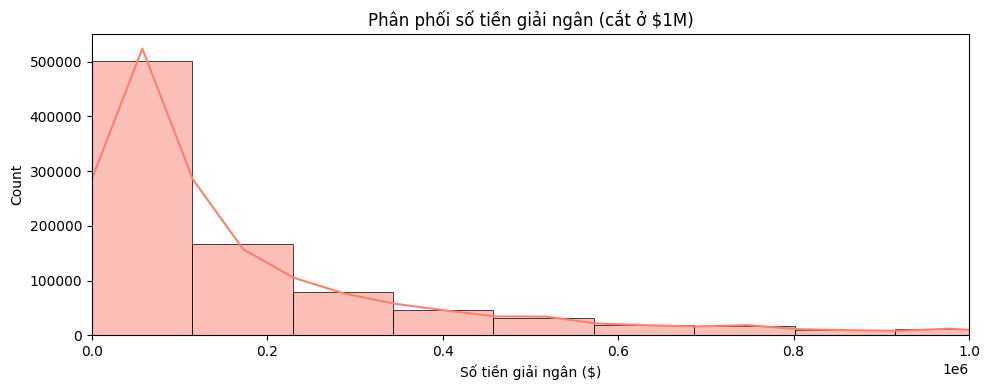

In [11]:
# --- Biểu đồ 2: Phân phối số tiền giải ngân ---
plt.figure(figsize=(10,4))
sns.histplot(df['DisbursementGross'], bins=100, kde=True, color='salmon')
plt.title("Phân phối số tiền giải ngân (cắt ở $1M)")
plt.xlabel("Số tiền giải ngân ($)")
plt.xlim(0, 1_000_000)  # Giới hạn để dễ nhìn
plt.tight_layout()
plt.show()

### 2. Phân phối số tiền giải ngân

Xu hướng: Phần lớn khoản vay có giá trị nhỏ (dưới 200.000 USD), rất ít khoản siêu lớn.

Kết luận: SBA chủ yếu hỗ trợ các khoản vay nhỏ, phù hợp với mục tiêu hỗ trợ doanh nghiệp nhỏ. Một số ít khoản vay lớn là ngoại lệ.

## 🔍 Tình trạng hệ thống MIS và khả năng bị xóa nợ

Biểu đồ cột phân tích xem trạng thái nào có nhiều khoản vay bị xoá nợ nhất.


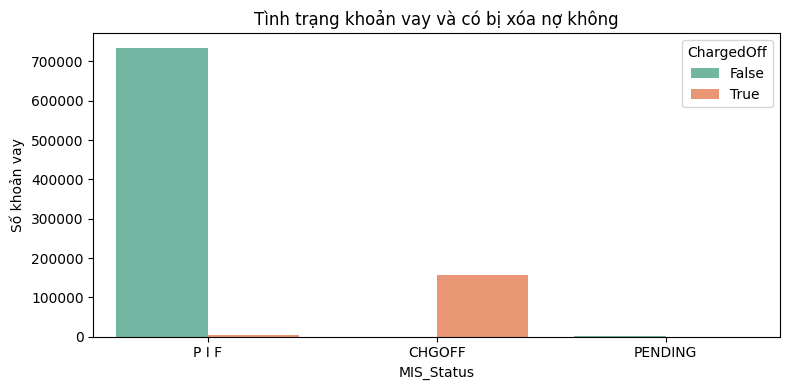

In [12]:
# --- Biểu đồ 3: Trạng thái MIS và khoản vay có bị xóa nợ ---
plt.figure(figsize=(8,4))
sns.countplot(data=df, x='MIS_Status', hue='ChargedOff', palette='Set2')
plt.title("Tình trạng khoản vay và có bị xóa nợ không")
plt.xlabel("MIS_Status")
plt.ylabel("Số khoản vay")
plt.tight_layout()
plt.show()

### 3. Tình trạng khoản vay và khả năng bị xóa nợ
Xu hướng: Đa số khoản vay có trạng thái "P I F" (đã trả hết), một phần nhỏ bị "CHGOFF" (xóa nợ). Hầu như chỉ các khoản "CHGOFF" mới bị xóa nợ.

Kết luận: Tỷ lệ xóa nợ thấp, cho thấy phần lớn doanh nghiệp trả được nợ. Tuy nhiên, nhóm bị xóa nợ tập trung chủ yếu ở trạng thái "CHGOFF".

## 🗺️ Top 10 bang có SBA bảo lãnh trung bình cao nhất

Bang nào có mức hỗ trợ từ SBA cao nhất tính theo trung bình? Biểu đồ ngang giúp so sánh dễ dàng.


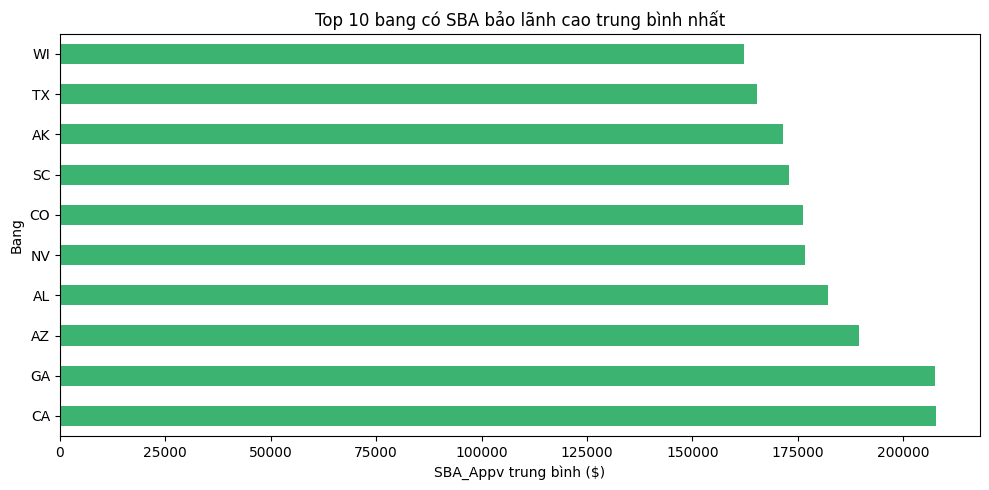

In [13]:
# --- Biểu đồ 4: Trung bình số tiền SBA bảo lãnh theo bang ---
top_states = df.groupby('State')['SBA_Appv'].mean().sort_values(ascending=False).head(10)

plt.figure(figsize=(10,5))
top_states.plot(kind='barh', color='mediumseagreen')
plt.title("Top 10 bang có SBA bảo lãnh cao trung bình nhất")
plt.xlabel("SBA_Appv trung bình ($)")
plt.ylabel("Bang")
plt.tight_layout()
plt.show()

### 4. Top 10 bang có SBA bảo lãnh trung bình cao nhất

Xu hướng: Các bang như CA, GA, AZ, AL, NV... có mức SBA bảo lãnh trung bình cao nhất.

Kết luận: Một số bang nhận được khoản bảo lãnh lớn hơn trung bình, có thể do quy mô doanh nghiệp hoặc đặc thù kinh tế địa phương.

## ♻️ Tương quan giữa các biến số tài chính và việc làm

Phân tích mối liên hệ giữa các biến như số tiền giải ngân, bảo lãnh, xoá nợ và số việc làm.


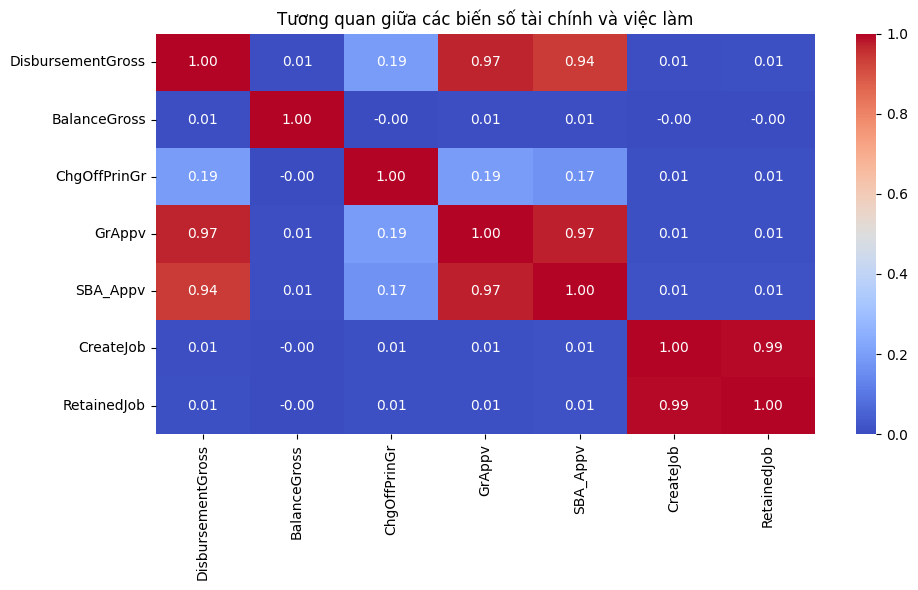

In [14]:
# --- Biểu đồ 5: Heatmap tương quan các biến số lượng ---
plt.figure(figsize=(10,6))
corr_cols = ['DisbursementGross', 'BalanceGross', 'ChgOffPrinGr', 'GrAppv', 'SBA_Appv', 'CreateJob', 'RetainedJob']
sns.heatmap(df[corr_cols].corr(), annot=True, cmap="coolwarm", fmt=".2f")
plt.title("Tương quan giữa các biến số tài chính và việc làm")
plt.tight_layout()
plt.show()

### 5. Tương quan giữa các biến số tài chính và việc làm

Xu hướng: Số tiền giải ngân, số tiền được SBA bảo lãnh, và số tiền được phê duyệt có tương quan rất cao với nhau. Số việc làm tạo mới và giữ lại cũng tương quan mạnh với nhau, nhưng yếu với các biến tài chính.

Kết luận: Các biến tài chính liên quan chặt chẽ với nhau, nhưng không phản ánh rõ rệt đến số việc làm tạo ra/giữ lại.

# 🧾 Kết luận tổng quan về bộ dữ liệu **SBAnational**

📌 **Bộ dữ liệu SBAnational.csv** phản ánh rõ nét tác động của chương trình hỗ trợ doanh nghiệp nhỏ (SBA) tại Mỹ. Qua phân tích, ta rút ra được những điểm chính sau:

---

✅ **1. Hiệu quả hỗ trợ vốn vay**  
Chương trình SBA đã cung cấp vốn vay quy mô lớn trong giai đoạn **1995–2007**, phần lớn tập trung vào **các khoản vay nhỏ**, đúng với định hướng hỗ trợ doanh nghiệp quy mô nhỏ và siêu nhỏ.

✅ **2. Tỷ lệ xóa nợ thấp**  
Hầu hết doanh nghiệp đều hoàn trả được nợ, thể hiện **cơ chế kiểm soát rủi ro hiệu quả** và quy trình xét duyệt khoản vay có chọn lọc.

✅ **3. Chênh lệch vùng miền rõ rệt**  
Một số bang có mức **bảo lãnh SBA trung bình cao hơn**, cho thấy **sự khác biệt về nhu cầu tài chính** và quy mô doanh nghiệp giữa các vùng địa lý.

✅ **4. Mối liên hệ giữa các biến tài chính**  
Các biến như `DisbursementGross`, `SBA_Appv`, `GrAppv` có **tương quan chặt chẽ**, nhưng ảnh hưởng của chúng đến số việc làm được tạo/gìn giữ lại **chưa rõ rệt** trong dữ liệu.

---

🌟 **Tổng kết:**  
Bộ dữ liệu SBAnational cho thấy SBA là **một trụ cột tài chính quan trọng** trong việc phát triển doanh nghiệp nhỏ và **ổn định kinh tế địa phương**. Đây cũng là một nguồn dữ liệu tiềm năng cho các mô hình dự đoán rủi ro và ra quyết định tài chính.

---
